# Import packages needed

In [1]:
import pandas as pd
import numpy as np
import shap

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, accuracy_score

# Utility functions
## Below are a few utility functions that can help generate additional features and enrich dataset

In [2]:
def add_multiple_rolling_means(df, column, windows):
    """
    Given a DataFrame, a column name, and a list of window sizes, this function:
    1. Computes the rolling mean for each window size and adds new columns to the DataFrame.
    2. Plots the original column and the newly created rolling mean columns on the same figure.
    """
    df = df.copy()

    # Compute rolling means and create new columns
    rolling_cols = []
    for w in windows:
        new_col_name = f'{column} {w}D Mean'
        df[new_col_name] = df[column].rolling(window=w).mean()
        rolling_cols.append(new_col_name)

    # Plot the original column and the rolling mean columns
    plot_cols = [column] + rolling_cols
    df[plot_cols].plot(figsize=(10, 6))
    plt.title(f"{column} with Rolling Means")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()

    return df

def add_column_differences(df, target_col, cols):
    """
    Given a DataFrame, a target column, and a list of other column names, calculates the difference between the target column and each of the listed columns, and creates new columns with the results.
    """
    df = df.copy()
    for c in cols:
        df[f'{c} - {target_col}'] = df[c] - df[target_col]
    return df

# Load data

In [3]:
data = pd.read_excel('Data Intel Project - Data Only.xlsx', sheet_name=['Returns Static'], engine='openpyxl')['Returns Static'].drop(columns = 'Unnamed: 2').set_index('Date')

# Handle outlier in Economic Index column

In the Economic Index column, we have some entries recorded as 200, and others with extremely large values. Based on prior knowledge, it appears that these large values are due to a missing decimal separator. To correct them, we can divide these extreme values by 1000 to restore them to their intended scale. For entries that are exactly 200, we will apply a linear interpolation at a later stage to replace them with more realistic values consistent with the rest of the dataset.

In [4]:
data.loc[data['Economic Index']>200, 'Economic Index'] = data.loc[data['Economic Index']>200, 'Economic Index'] / 1000
data.loc[data['Economic Index']>=200, 'Economic Index'] = np.nan

# Feature energing

## We made a log transfrom to the "Stock Market"

In [5]:
data['Stock Market Log Scale'] = np.log(data['Stock Market'])

## Transform RSI into Binary Variables

In [6]:
data['RSI Oversold'] = data['RSI'] < 30
data['RSI Neutral'] = data['RSI'].between(30, 70, inclusive='both')
data['RSI Overbought'] = data['RSI'] > 70

## Smoothing
Cloumn "New Sentiment" , "Economic Index" “Commodities Price Index”，are volatie on a day by day basis, here we use N day moving average to smoothe them

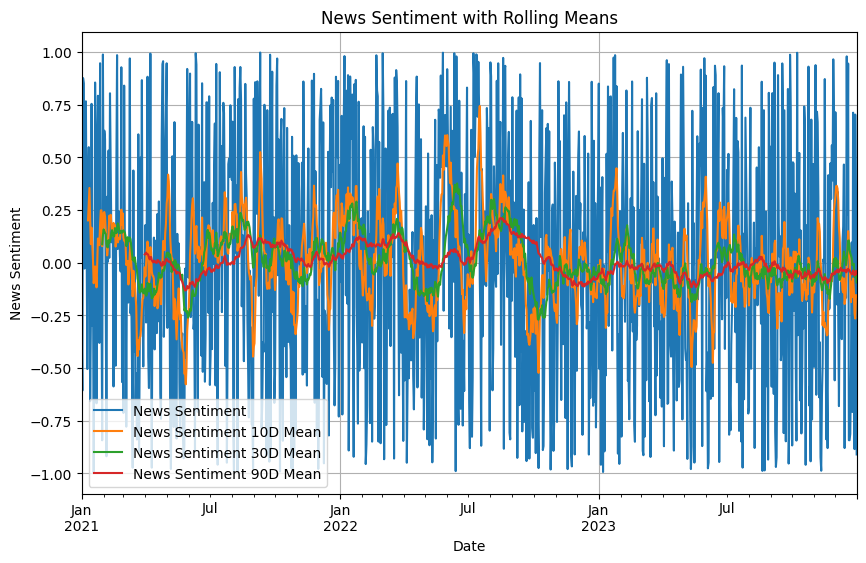

In [7]:
data = add_multiple_rolling_means(data, 'News Sentiment', [10, 30, 90])

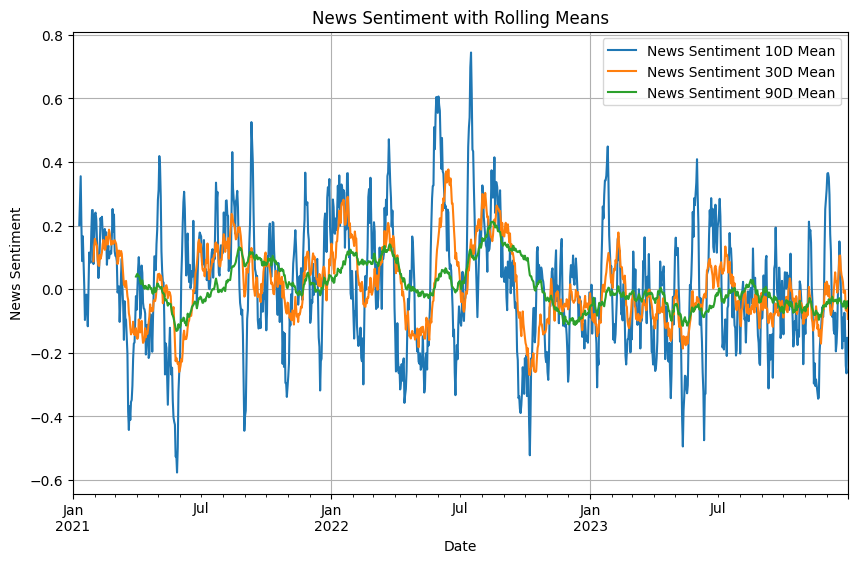

In [8]:
plot_cols =  ['News Sentiment 10D Mean', 'News Sentiment 30D Mean', 'News Sentiment 90D Mean']

data[plot_cols].plot(figsize=(10, 6), ax = plt.gca())

plt.title("News Sentiment with Rolling Means")
plt.xlabel("Date")
plt.ylabel("News Sentiment")
plt.legend()
plt.grid()
plt.show()

In [9]:
data.dropna(subset=['Stock Market'], inplace=True)

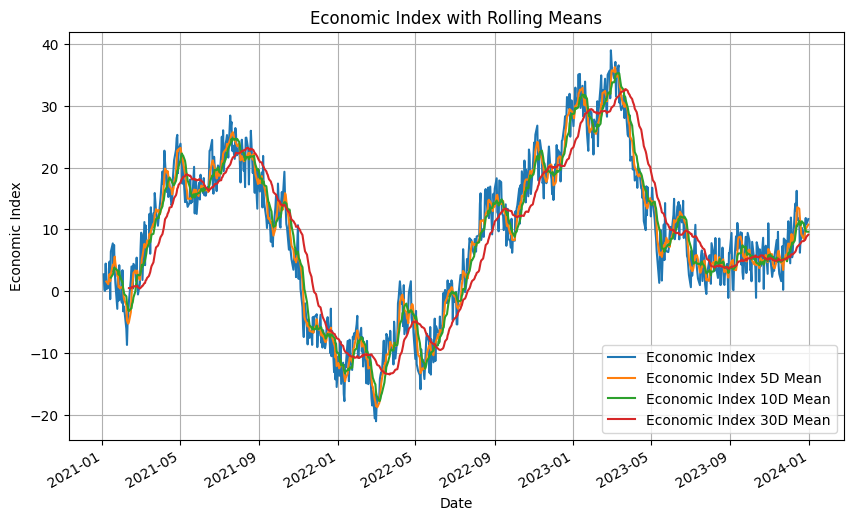

In [10]:
data['Economic Index'] = data['Economic Index'].interpolate(method='linear', axis=0).ffill()
data = add_multiple_rolling_means(data, 'Economic Index', [5, 10, 30])

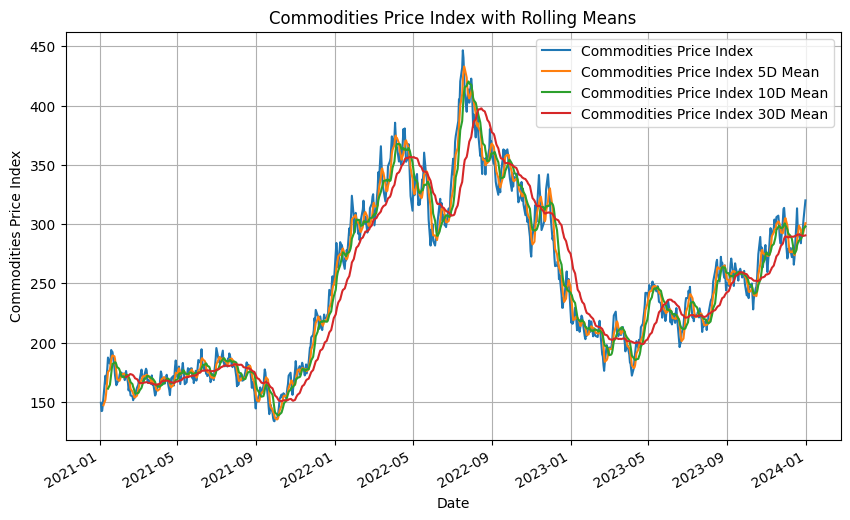

In [11]:
data = add_multiple_rolling_means(data, 'Commodities Price Index', [5, 10, 30])

we also smootth out lag scaled price, this will be used to indicate the trend between different terms

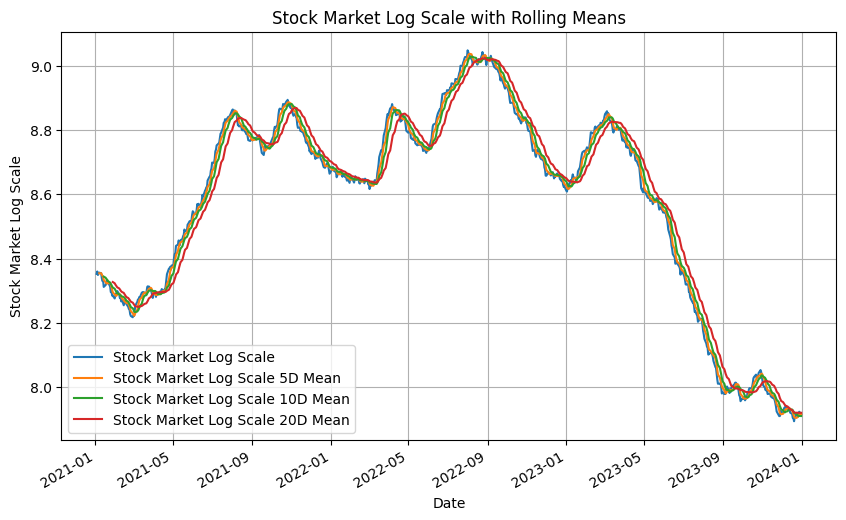

In [12]:
data = add_multiple_rolling_means(data, 'Stock Market Log Scale', [5, 10, 20])

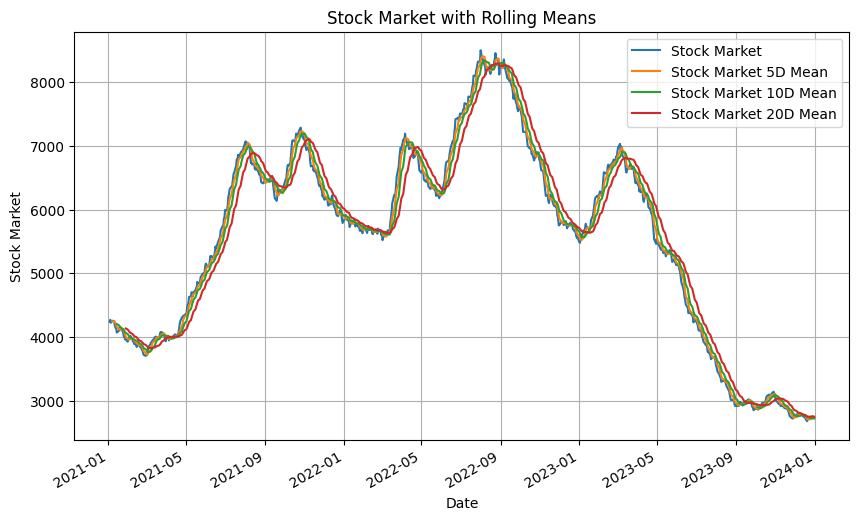

In [13]:
data = add_multiple_rolling_means(data, 'Stock Market', [5, 10, 20])

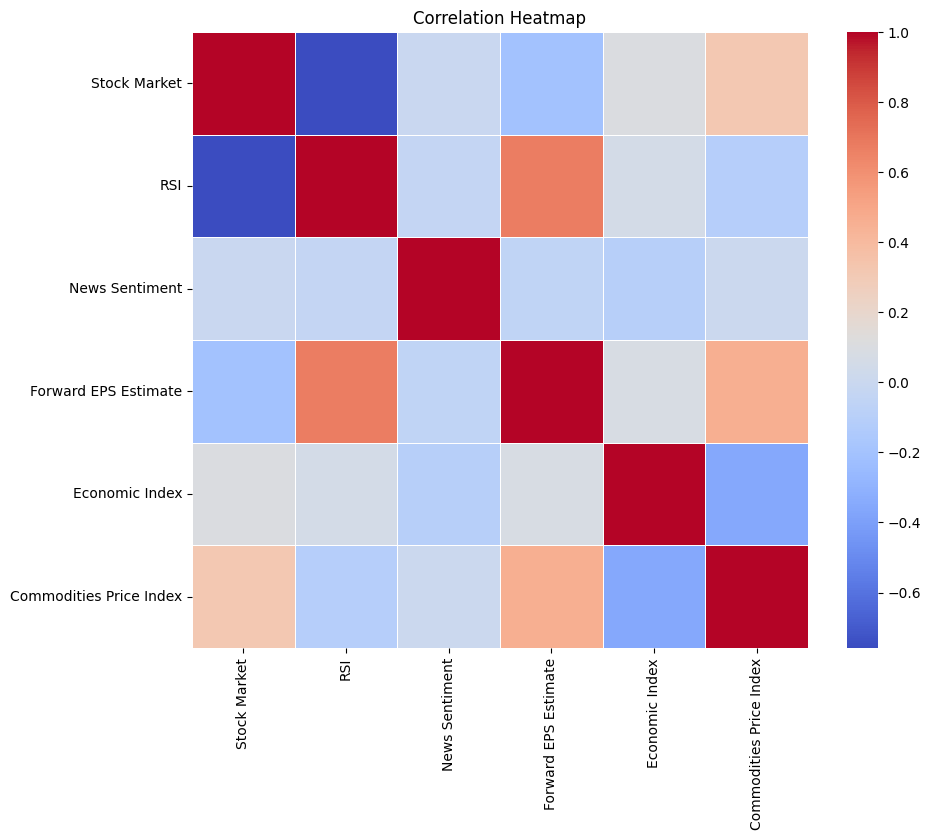

In [14]:
corr_matrix = data[['Stock Market', 'RSI', 'News Sentiment', 'Forward EPS Estimate', 'Economic Index', 'Commodities Price Index']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5
)
plt.title('Correlation Heatmap')
plt.show()

## Differicing
We will further enhance our feature set by calculating differences between various N-day moving averages. The rationale behind this is that these differences can highlight the relative strength of the underlying trend.

In [15]:
data = add_column_differences(data, 'Stock Market Log Scale 20D Mean', ['Stock Market Log Scale 5D Mean', 'Stock Market Log Scale 10D Mean'])
data = add_column_differences(data, 'News Sentiment 90D Mean', ['News Sentiment 10D Mean', 'News Sentiment 30D Mean'])
data = add_column_differences(data, 'Commodities Price Index 30D Mean', ['Commodities Price Index 5D Mean', 'Commodities Price Index 10D Mean'])
data = add_column_differences(data, 'Economic Index 30D Mean', ['Economic Index 5D Mean', 'Economic Index 10D Mean'])

# Modeling
All the features we’ve created are based on historical data, which prevents any risk of data leakage. We will use a selection of these features—under the assumption of a 10-day holding period—to predict the probability that the price will rise or fall over the following 10 days.

In [16]:
features = ['RSI Oversold',
            'RSI Neutral',
            'RSI Overbought',
            'Stock Market Log Scale 5D Mean - Stock Market Log Scale 20D Mean',
            'Stock Market Log Scale 10D Mean - Stock Market Log Scale 20D Mean',
            'Economic Index 5D Mean - Economic Index 30D Mean',
            'Economic Index 10D Mean - Economic Index 30D Mean',
            'News Sentiment 10D Mean - News Sentiment 90D Mean',
            'News Sentiment 30D Mean - News Sentiment 90D Mean',
            'Commodities Price Index 5D Mean - Commodities Price Index 30D Mean',
            'Commodities Price Index 10D Mean - Commodities Price Index 30D Mean']
data['Stock Market Log Scale 10D Move'] = data['Stock Market Log Scale'].shift(-10) - data['Stock Market Log Scale']

In [17]:
corr_matrix = data[features+['Stock Market Log Scale 10D Move']].corr()

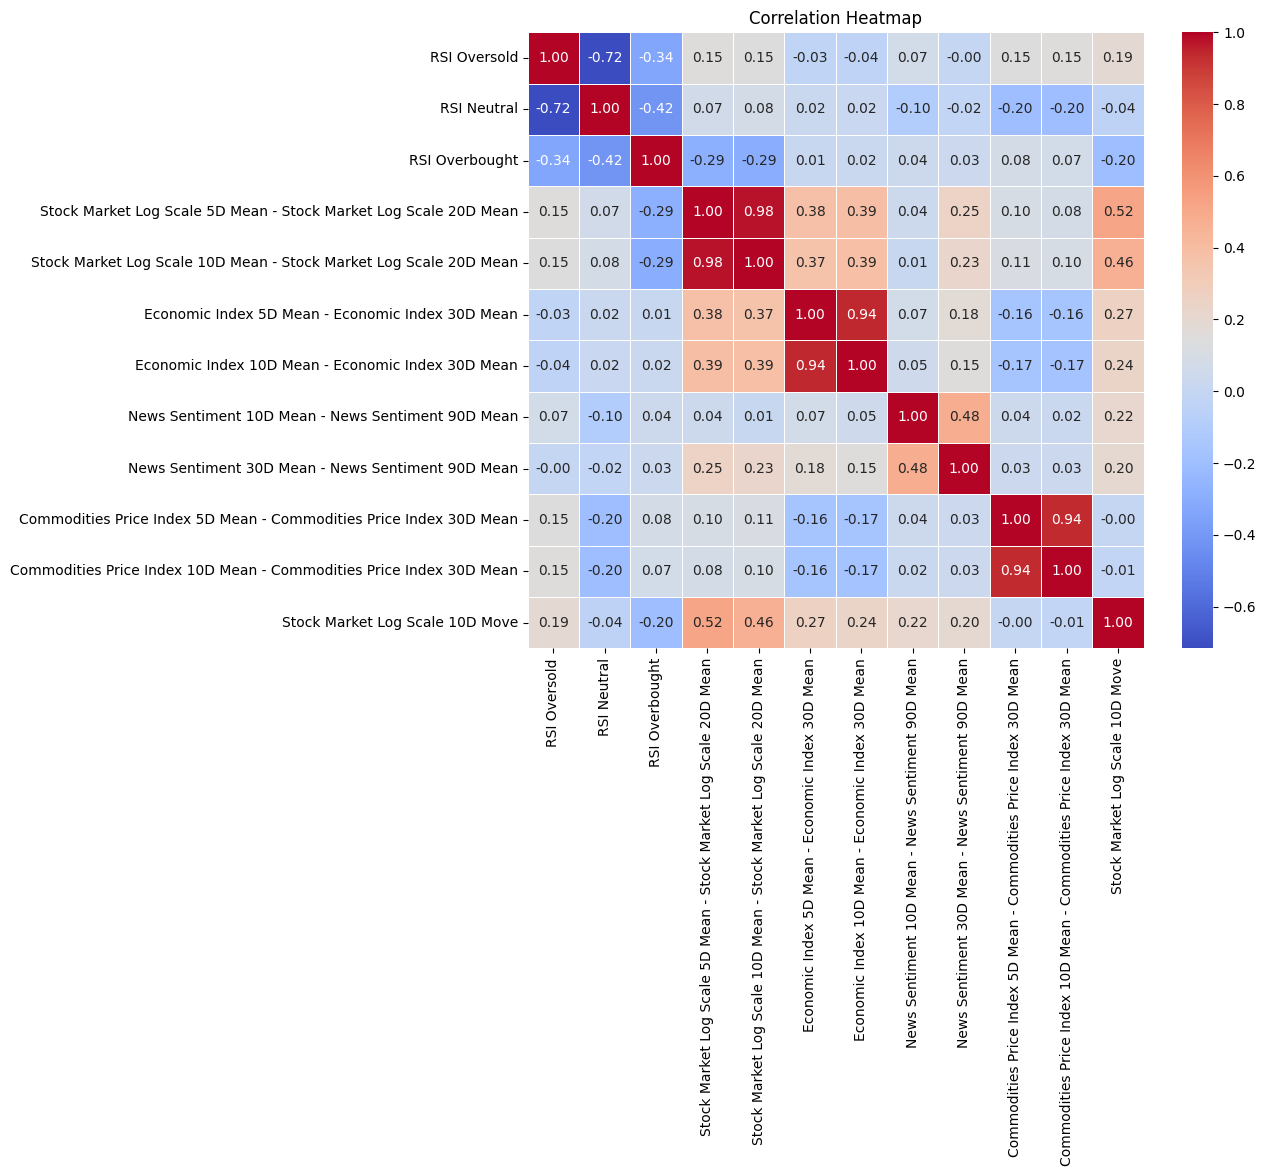

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5
)
plt.title('Correlation Heatmap')
plt.show()

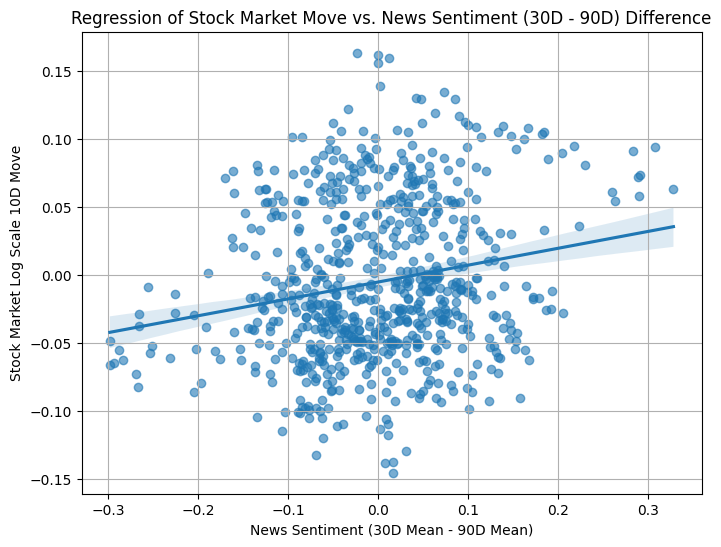

In [19]:
x_col = 'News Sentiment 30D Mean - News Sentiment 90D Mean'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression of Stock Market Move vs. News Sentiment (30D - 90D) Difference')
plt.xlabel('News Sentiment (30D Mean - 90D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid()
plt.show()

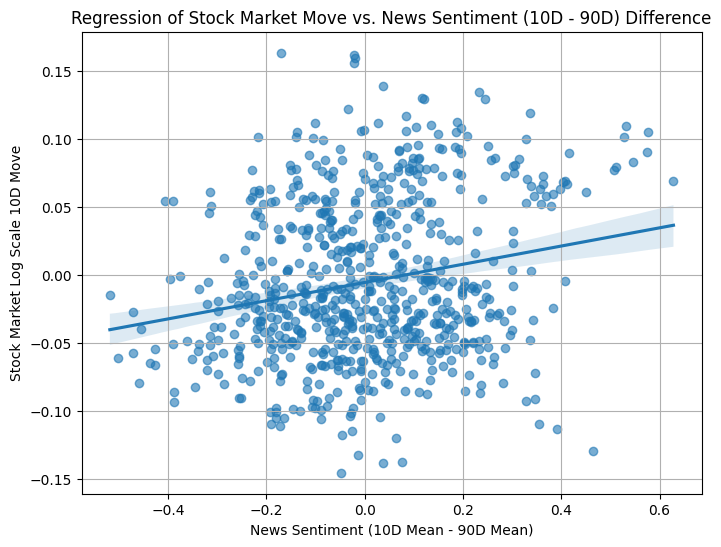

In [20]:
x_col = 'News Sentiment 10D Mean - News Sentiment 90D Mean'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression of Stock Market Move vs. News Sentiment (10D - 90D) Difference')
plt.xlabel('News Sentiment (10D Mean - 90D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid()
plt.show()

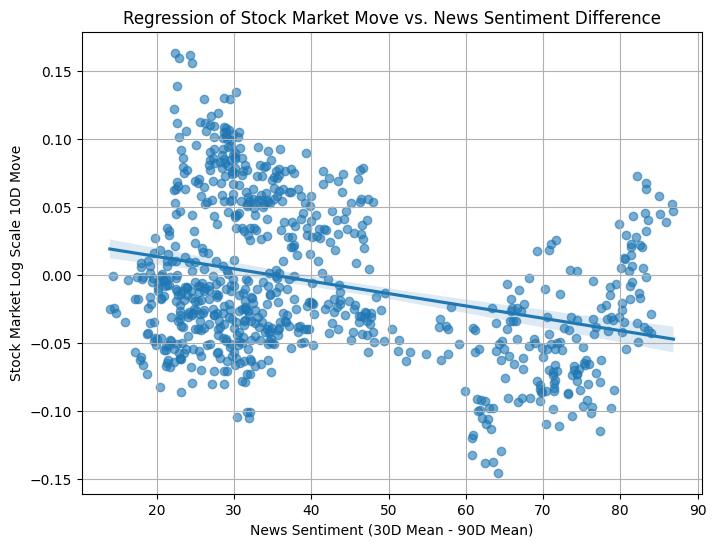

In [21]:
x_col = 'RSI'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression of Stock Market Move vs. News Sentiment Difference')
plt.xlabel('News Sentiment (30D Mean - 90D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid()
plt.show()

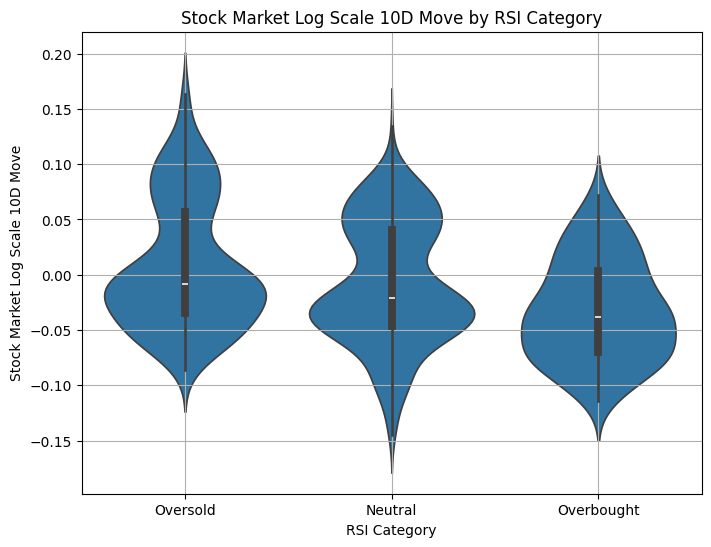

In [22]:
data['RSI Category'] = pd.cut(
    data['RSI'],
    bins=[0, 30, 70, 100],
    labels=['Oversold', 'Neutral', 'Overbought']
)

plt.figure(figsize=(8, 6))

sns.violinplot(
    x='RSI Category',
    y='Stock Market Log Scale 10D Move',
    data=data
)

plt.title('Stock Market Log Scale 10D Move by RSI Category')
plt.xlabel('RSI Category')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid(True)
plt.show()

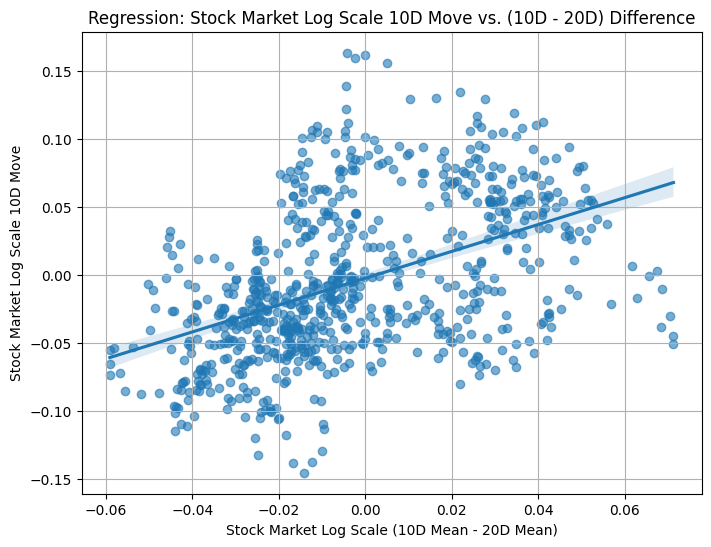

In [23]:
x_col = 'Stock Market Log Scale 10D Mean - Stock Market Log Scale 20D Mean'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression: Stock Market Log Scale 10D Move vs. (10D - 20D) Difference')
plt.xlabel('Stock Market Log Scale (10D Mean - 20D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid(True)
plt.show()

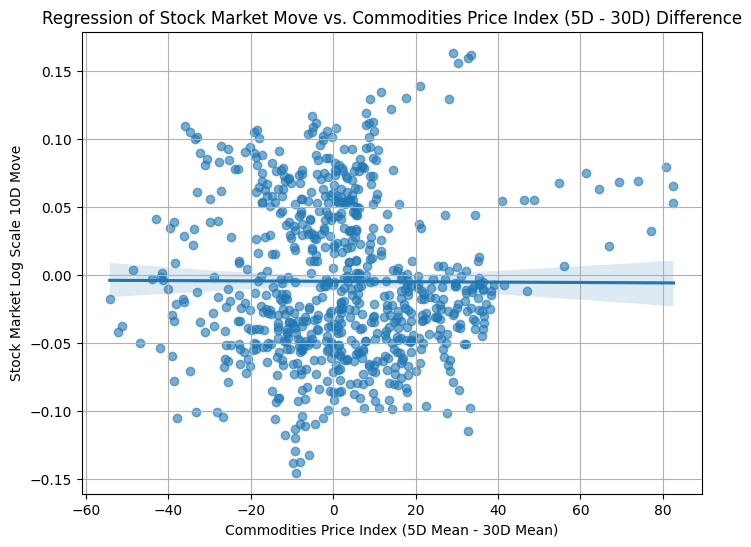

In [24]:
x_col = 'Commodities Price Index 5D Mean - Commodities Price Index 30D Mean'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression of Stock Market Move vs. Commodities Price Index (5D - 30D) Difference')
plt.xlabel('Commodities Price Index (5D Mean - 30D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid()
plt.show()

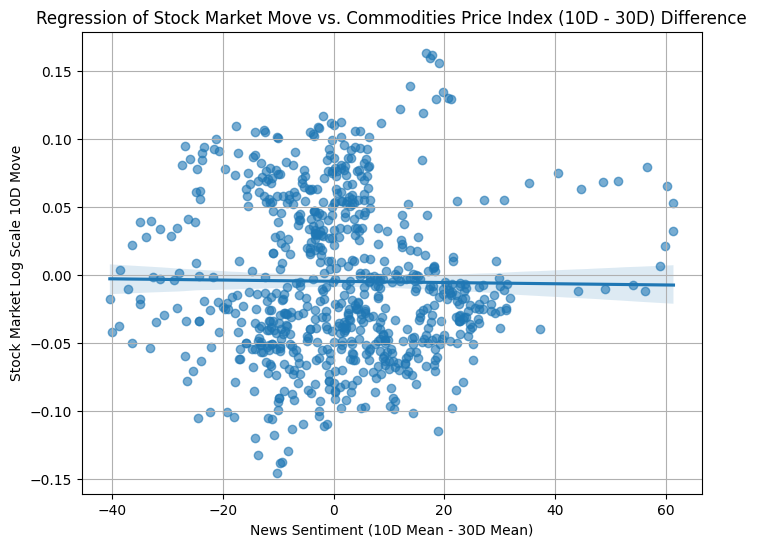

In [25]:
x_col = 'Commodities Price Index 10D Mean - Commodities Price Index 30D Mean'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression of Stock Market Move vs. Commodities Price Index (10D - 30D) Difference')
plt.xlabel('News Sentiment (10D Mean - 30D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid()
plt.show()

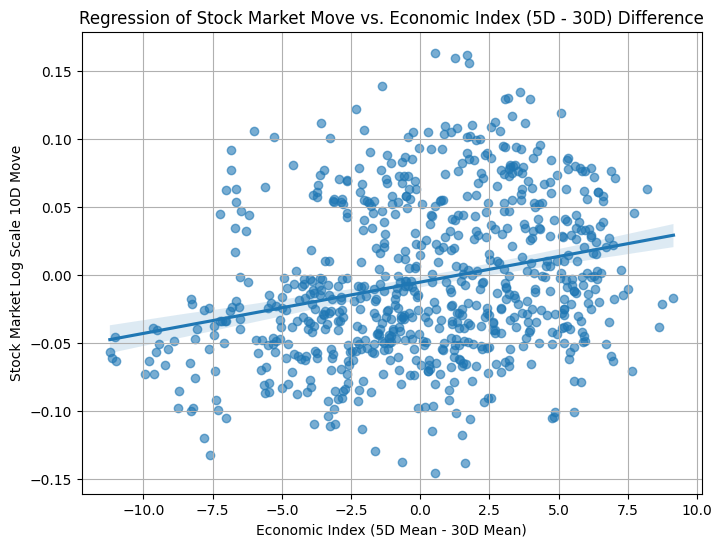

In [26]:
x_col = 'Economic Index 5D Mean - Economic Index 30D Mean'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression of Stock Market Move vs. Economic Index (5D - 30D) Difference')
plt.xlabel('Economic Index (5D Mean - 30D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid()
plt.show()

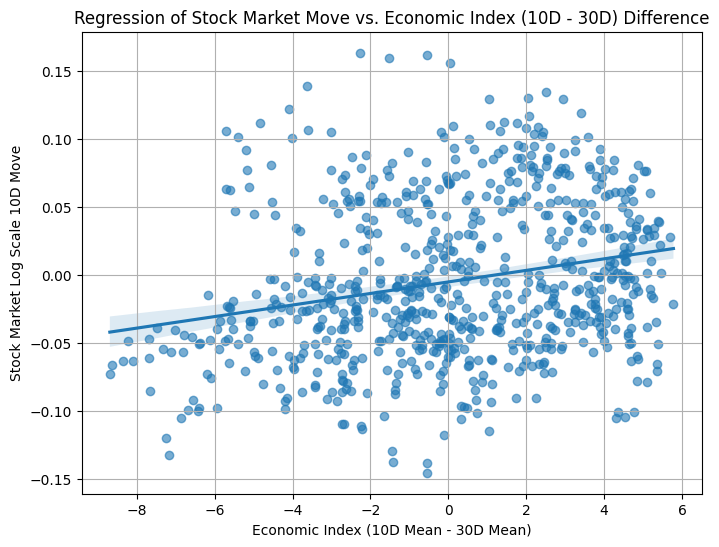

In [27]:
x_col = 'Economic Index 10D Mean - Economic Index 30D Mean'
y_col = 'Stock Market Log Scale 10D Move'

plt.figure(figsize=(8, 6))

sns.regplot(
    x=x_col,
    y=y_col,
    data=data,
    ci=95,
    scatter_kws={'alpha': 0.6}
)

plt.title('Regression of Stock Market Move vs. Economic Index (10D - 30D) Difference')
plt.xlabel('Economic Index (10D Mean - 30D Mean)')
plt.ylabel('Stock Market Log Scale 10D Move')
plt.grid()
plt.show()

In [28]:
data = data.drop(columns = 'Average Precipitation over last month').dropna()

In [29]:
features = ['Stock Market Log Scale 5D Mean - Stock Market Log Scale 20D Mean',
            'Commodities Price Index 5D Mean - Commodities Price Index 30D Mean',
            'News Sentiment 10D Mean - News Sentiment 90D Mean',
            'Economic Index 5D Mean - Economic Index 30D Mean'
            ]

Using a binary definition for y can oversimplify the target variable by ignoring its scale. However, for simplicity, we define y as whether the stock price will be higher in 10 days.

In [30]:
X = data[features].values
y = data['Stock Market Log Scale 10D Move'] > 0

In [31]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [10, 30, 60, 90],
    'max_depth': [5, 10, 15]
}

rf = RandomForestClassifier(random_state=42)

# Using 'roc_auc' scoring to measure how well the model distinguishes upward moves
grid = GridSearchCV(rf, param_grid, cv=tscv, scoring='roc_auc', n_jobs=-1)
grid.fit(X, y)
best_model = grid.best_estimator_

In [32]:
best_model

RandomForestClassifier(max_depth=5, n_estimators=30, random_state=42)

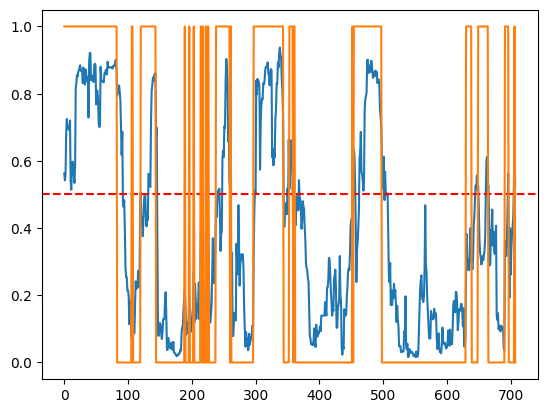

In [33]:
plt.plot(best_model.predict_proba(X)[:,1])
plt.axhline(y=0.5, color='red', linestyle='--')
plt.plot(y.values)

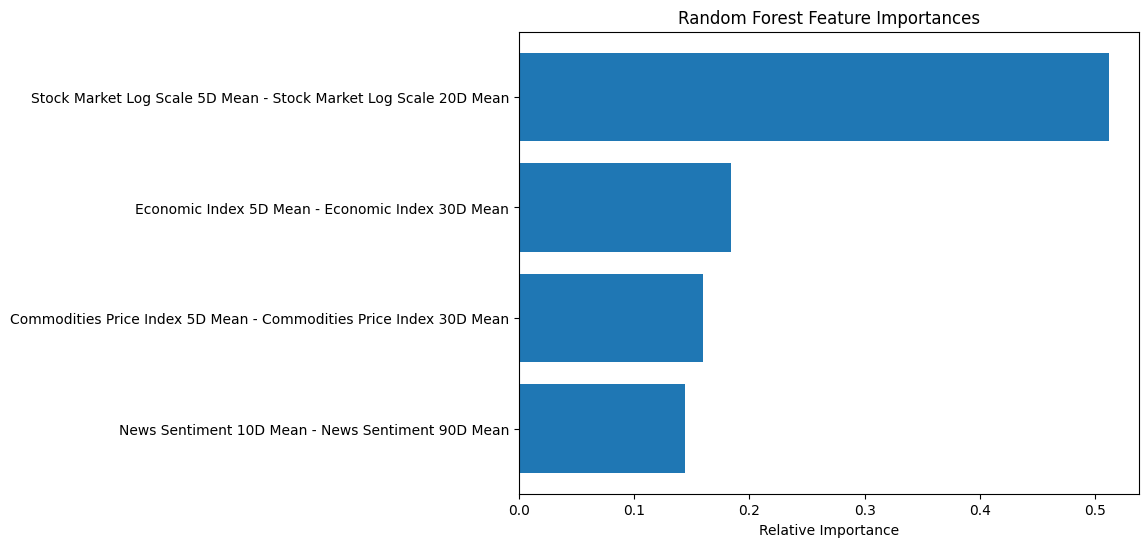

In [34]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Random Forest Feature Importances')
plt.show()

In [35]:
X = X.astype(np.float64)

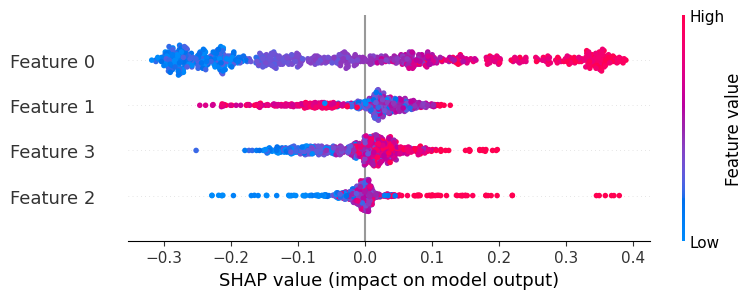

In [36]:
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)
shap_values_class1 = shap_values[:, :, 1]
shap.summary_plot(shap_values_class1, X)

In [37]:
dict(zip(range(len(features)),features))

{0: 'Stock Market Log Scale 5D Mean - Stock Market Log Scale 20D Mean',
 1: 'Commodities Price Index 5D Mean - Commodities Price Index 30D Mean',
 2: 'News Sentiment 10D Mean - News Sentiment 90D Mean',
 3: 'Economic Index 5D Mean - Economic Index 30D Mean'}

# Backtest

In [38]:
def sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    """
    Calculate the annualized Sharpe Ratio.
    """
    returns = pd.Series(returns)
    avg_return_periodic = returns.mean()
    avg_return_annualized = avg_return_periodic * periods_per_year
    std_return_periodic = returns.std()
    std_return_annualized = std_return_periodic * np.sqrt(periods_per_year)
    sharpe = (avg_return_annualized - risk_free_rate) / std_return_annualized
    return sharpe


In [39]:
def train_and_predict(X, y, train_indices, test_indices, model):
    X_train, X_test = X[train_indices, :], X[test_indices, :]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    priority_prob = (y_train.sum()/len(y_train))

    return y_test, y_pred, priority_prob

def initialize_price_history(data, y_test, y_pred):
    price_history = data.loc[y_test.index, :].copy().reset_index()
    price_history['rise_probability'] = y_pred[:, 1]
    price_history['y_test'] = y_test.astype(int)
    return price_history

def execute_trading_strategy(price_history, initial_fund=10000, threshold=0.5):
    fund = initial_fund
    portfolio = {}
    i = 0

    while i < price_history.shape[0]:
        if (price_history.iloc[i]['rise_probability'] > threshold) and (i + 10 < price_history.shape[0]):
            #print(f"buy at {price_history.iloc[i]['Date']}")
            share_hold = fund / price_history.iloc[i]['Stock Market']
            i += 10
            fund = share_hold * price_history.iloc[i]['Stock Market']
            #print(f"exit with {int(fund)}")
        else:
            i += 1

        portfolio[i] = fund

    return portfolio

def calculate_buy_and_hold(price_history, initial_fund=10000):
    first_price = price_history['Stock Market'].iloc[0]
    shares_bh = initial_fund / first_price
    price_history['buy&hold'] = shares_bh * price_history['Stock Market']
    return price_history

def finalize_portfolio(price_history, portfolio):
    portfolio_series = pd.Series(portfolio)
    full_range = range(0, portfolio_series.index.max() + 1)
    portfolio_series = portfolio_series.reindex(full_range)

    price_history['portfolio'] = (
        (portfolio_series / price_history['Stock Market'])
        .ffill() * price_history['Stock Market']
    ).fillna(price_history['buy&hold'])

    price_history['strategy'] = price_history['portfolio']
    return price_history

def calculate_sharpe_ratios(price_history, sharpe_ratio_func):
    strategy_returns = price_history['strategy'].pct_change()
    bh_returns = price_history['buy&hold'].pct_change()

    sr_strategy = sharpe_ratio_func(strategy_returns)
    sr_buy_hold = sharpe_ratio_func(bh_returns)

    return sr_strategy, sr_buy_hold


In [40]:
def run_backtest(X, y, tscv, best_model, data, sharpe_ratio_func):
    results = []

    for j, (train_indices, test_indices) in enumerate(tscv.split(X)):
        y_test, y_pred, priority_prob = train_and_predict(X, y, train_indices, test_indices, best_model)
        price_history = initialize_price_history(data, y_test, y_pred)

        portfolio = execute_trading_strategy(price_history, threshold=priority_prob)
        price_history = calculate_buy_and_hold(price_history)
        price_history = finalize_portfolio(price_history, portfolio)

        sr_strategy, sr_buy_hold = calculate_sharpe_ratios(price_history, sharpe_ratio_func)

        #print(f"Fold {j} - Sharpe(Strategy): {sr_strategy:.3f} | Sharpe(Buy&Hold): {sr_buy_hold:.3f}")

        results.append({
            'fold': j,
            'sharpe_strategy': sr_strategy,
            'sharpe_buy_and_hold': sr_buy_hold,
            'price_history': price_history.copy()
        })

    return results

In [41]:
results = run_backtest(X, y, tscv, best_model, data, sharpe_ratio)


In [42]:
strategy_sharpes = [results[i]['sharpe_strategy'] for i in range(5)]
buyhold_sharpes = [results[i]['sharpe_buy_and_hold'] for i in range(5)]
time_range = [results[i]['price_history']['Date'].min().strftime('%Y-%m-%d') + ' to ' + results[i]['price_history']['Date'].max().strftime('%Y-%m-%d') for i in range(5)]

sharpes = pd.DataFrame({
    'Testing Window': time_range,
    'Sharpe (Strategy)': strategy_sharpes,
    'Sharpe (Buy & Hold)': buyhold_sharpes

})

In [43]:
sharpes

,Testing Window,Sharpe (Strategy),Sharpe (Buy & Hold)
0,2021-09-13 to 2022-02-23,0.055108,-1.630733
1,2022-02-24 to 2022-08-08,5.380736,4.851146
2,2022-08-09 to 2023-01-19,-2.457180,-4.682397
3,2023-01-22 to 2023-07-04,0.576926,-4.396970
4,2023-07-05 to 2023-12-17,-1.586221,-5.648213


In [44]:
returns = []
for i in range(5):
    final_values = results[i]['price_history'][['strategy', 'buy&hold']].iloc[-1] / 100 - 100
    returns.append(final_values)

# Create a DataFrame from the results
returns_df = pd.DataFrame(returns, columns=['strategy', 'buy&hold'])
returns_df.reset_index(drop=True, inplace=True)
returns_df.columns = ['Strategy Return (%)', 'Buy & Hold Return (%)']

returns_df

,Strategy Return (%),Buy & Hold Return (%)
0,0.023758,-11.209722
1,44.841163,44.833802
2,-12.147490,-28.147975
3,2.722746,-29.527060
4,-5.694511,-33.143354


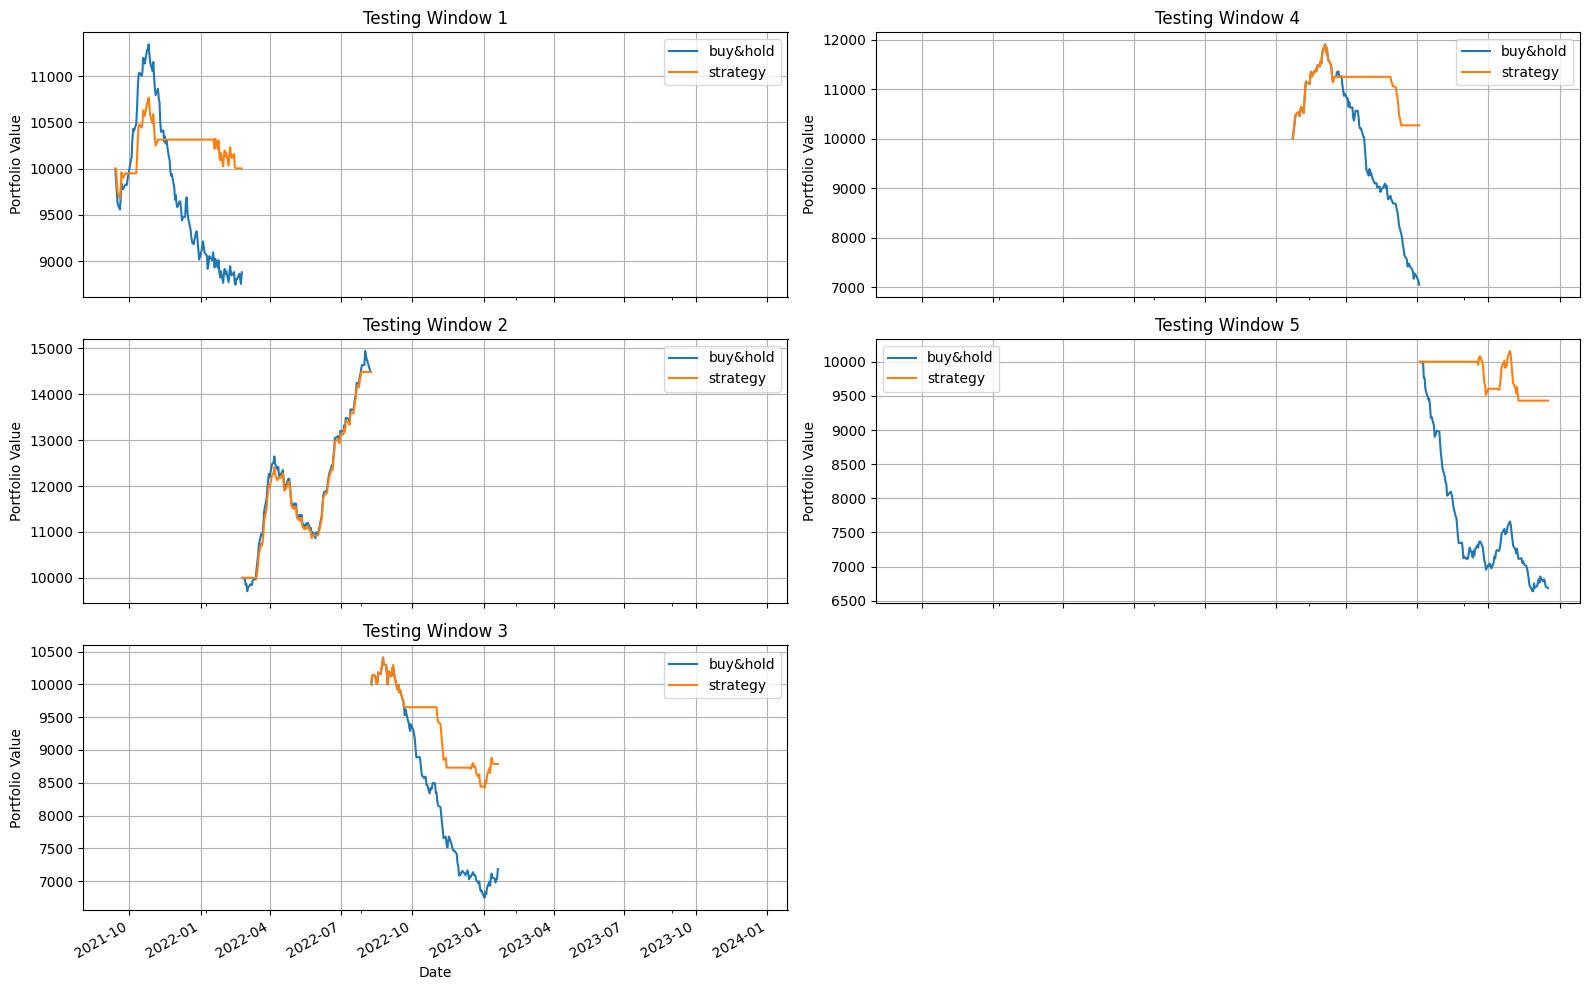

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10), sharex=True)

plot_order = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1)]

for i in range(5):
    r, c = plot_order[i]
    ax = axes[r, c]

    df_plot = results[i]['price_history'].set_index('Date')[['buy&hold', 'strategy']]
    df_plot.plot(ax=ax)

    ax.set_title(f'Testing Window {i+1}')
    ax.set_ylabel('Portfolio Value')
    ax.grid(True)

r, c = plot_order[5]  # (2, 1)
axes[r, c].axis('off')

plt.xlabel('Date')
plt.tight_layout()
plt.show()



